### Project Details:

Before you start Task 2, make sure you've read through the project description in "Project_AIPR.pdf" (used for all three tasks) found in the Files page.

If you need or want to you can remake anything from Task 1 to help complete Task 2. If you do, this should be documented and justified in the report.

### Overview:

Task 2 concerns the training and testing of some common classification models on the gesture data.
As part of this you will:

Train several different classifiers (Decision Tree, k-NN, MLP, and SVM) using the training set.
Evaluate their performance on the test set.
Reflect on the results and choices made.
Any files used or created in Task 1 can be used again for this task.

### Training

Train several different classifier models on the training set data after filling in the missing values and doing the preprocessing from Task 1.

At a minimum, you must use the following classifiers: Decision Tree, Random Forest, k-NN, MLP, and SVM. You may include additional classifiers.

For each classifier documents their performance, what training procedure you used, how you decided on what hyperparameters to use, and justify each of those choices with what is taught in this course as well as any self-taught material (though include sources for self-taught materials).

Note: For this task you should explicitly not use AutoMLP (it's a quite powerful tool that does many of the things that are supposed to be experimented with in the project automatically. Of course you can feel free to try it to see how it works, just don't include it in Task 2).

### Testing

For each classifier, make a selection of trained models to evaluate the test set and report the results. Document the results, how testing was performed, which models were selected for testing, and justify each of those choices.

### Reflection

Finally, reflect on which models perform well and not. How does what you did in this task relate to what has been taught in the course? What models are typically good on this problem and was this the case here? Why/why not? How can one find the best hyperparameters for the different classifiers?

### Submission

Like in the previous task there are two parts of the submission:

Implementation:
Any files/projects used that are different from those provided to you (including those files that you have edited and any files you have already submitted for a previous task).
Report:
Your documentation of how you solved the task and justification for the choices you made.

In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# Load the train dataset
df_train = pd.read_csv("train-final.csv", header=None)

#
# Rename columns for easier reading
#

# Feature columns
df_train.rename({i:f"positions_mean_{i}" for i in range(60)}, axis=1, inplace=True)
df_train.rename({i:f"positions_std_{i}" for i in range(60,120)}, axis=1, inplace=True)
df_train.rename({i:f"angles_mean_{i}" for i in range(120,180)}, axis=1, inplace=True)
df_train.rename({i:f"angles_std_{i}" for i in range(180,240)}, axis=1, inplace=True)

# Label columns
df_train.rename({240 : "label_name", 241 : "label_code"}, axis=1, inplace=True)

train_feature_columns = df_train.columns[:-2]
n_classes = df_train.label_name.nunique()

# Look for columns that have missing values
columns_null_sum = df_train.isnull().sum()
columns_with_nulls = columns_null_sum[columns_null_sum > 0]

# Replace missing values with numm
df_train[columns_with_nulls.index] = df_train[columns_with_nulls.index].fillna(df_train[columns_with_nulls.index].mean())

assert df_train.isnull().sum().sum() == 0

<AxesSubplot: >

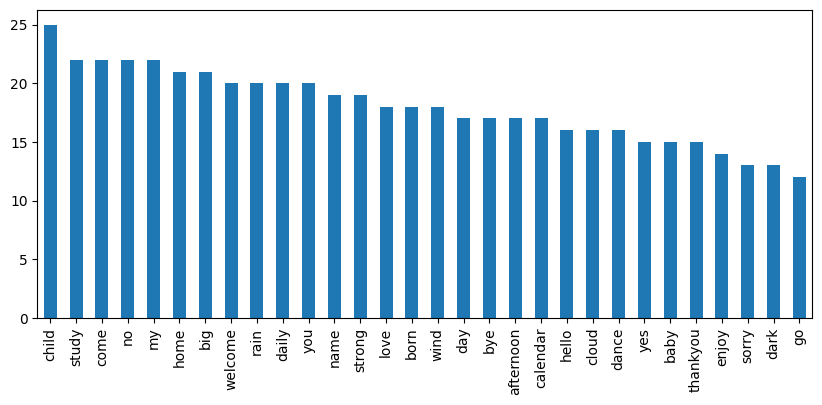

In [3]:
# Take a look at how many occurrences we have of each label
df_train.label_name.value_counts().plot(kind="bar", figsize=(10, 4))

In [4]:
# Preprocessing will use the standard scaler in Scikit learn which will normalize the data set (center and scale to the variance)
def preprocess(df):

    scaler = preprocessing.StandardScaler()
    scaled_values = scaler.fit_transform(df.values)
    return pd.DataFrame(scaled_values)

df_train[train_feature_columns] = preprocess(df_train[train_feature_columns])
df_train.head()

,positions_mean_0,positions_mean_1,positions_mean_2,positions_mean_3,positions_mean_4,positions_mean_5,positions_mean_6,positions_mean_7,positions_mean_8,positions_mean_9,...,angles_std_232,angles_std_233,angles_std_234,angles_std_235,angles_std_236,angles_std_237,angles_std_238,angles_std_239,label_name,label_code
0,-1.323633,1.421746,0.733025,-1.232600,1.399904,0.822277,-1.422333,1.264565,0.855193,-1.157657,...,1.047194,-1.135466,0.769486,0.395003,-0.513685,0.020178,2.181665,-1.544711,bye,5
1,1.003039,0.078953,0.794440,1.093898,-0.102009,0.757567,0.931582,0.171659,1.109858,0.937443,...,-1.823802,1.842487,-0.235120,-1.990480,1.426960,-0.876203,-2.053768,1.825020,you,30
2,0.764166,-0.293088,-0.930321,0.915639,-0.371414,-0.985672,0.729450,0.030518,-0.094503,0.854160,...,-0.791318,0.629031,1.002887,0.942327,-1.474741,0.680542,0.412169,-0.811236,thankyou,26
3,0.647555,0.376563,1.137173,0.735317,0.386874,0.780659,0.509463,0.333136,1.455556,0.664697,...,0.884029,-0.850038,-0.147232,-0.450141,0.702284,0.228297,1.694685,-1.276755,name,20
4,1.063069,-0.051572,0.467238,1.133087,-0.178730,0.337967,0.992393,0.077981,0.388881,1.137018,...,0.485131,0.432586,-0.583229,-0.954479,1.125046,-0.296817,1.861857,-1.176475,love,18


Explained variation per principal component: [0.10748785 0.09725905]
Total variance explained by 2 PCA components 0.20474690759247605


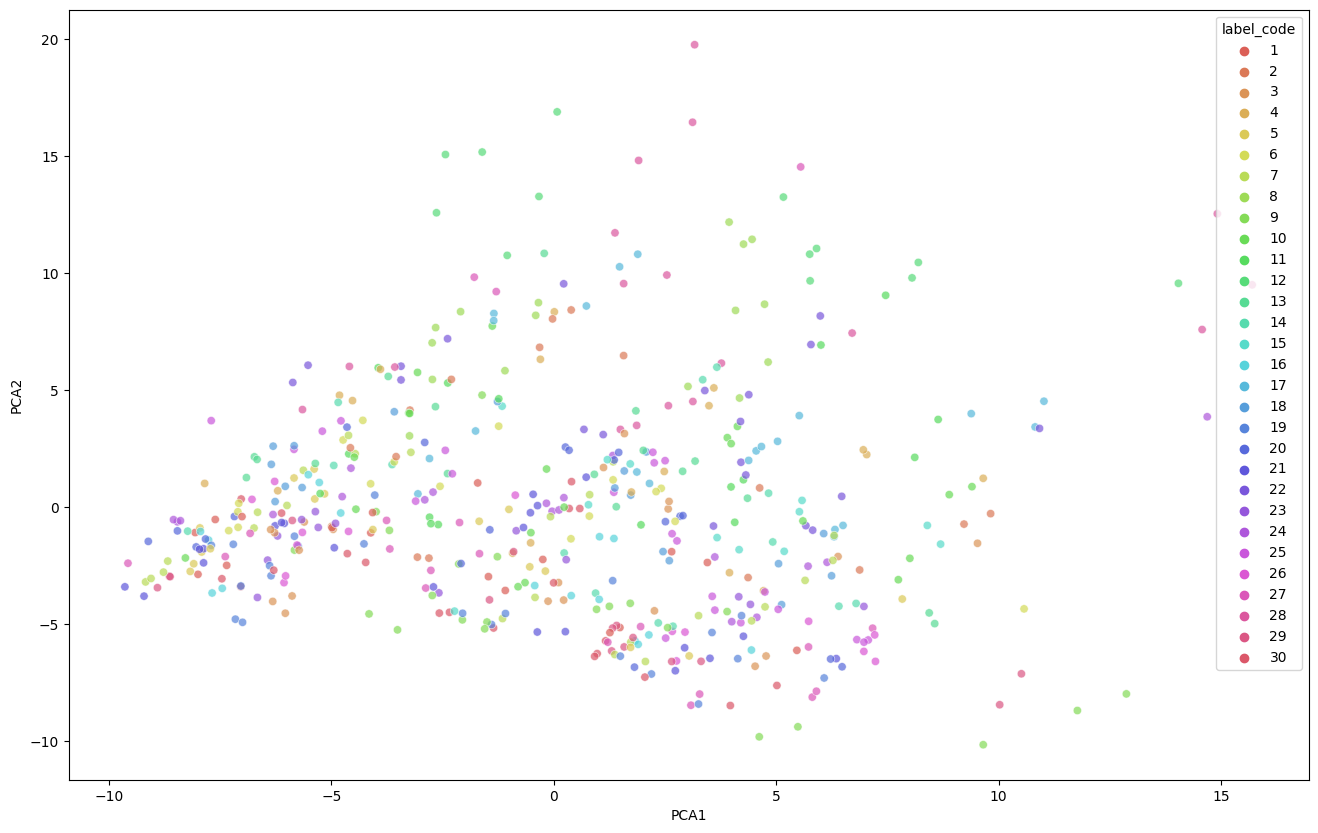

In [5]:


def PCA_scatter(df, feature_columns, label_column):

    df = df.copy()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(df[feature_columns].values)

    print(f"Explained variation per principal component: {pca.explained_variance_ratio_}")
    print(f"Total variance explained by {pca_result.shape[1]} PCA components", np.sum(pca.explained_variance_ratio_))

    df[['PCA1', 'PCA2']] = pca_result[:,:2]

    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="PCA1", y="PCA2",
        hue=label_column,
        palette=sns.color_palette("hls", n_classes),
        data=df,
        legend="full",
        alpha=0.7
    )

PCA_scatter(df_train, train_feature_columns, "label_code")

/Users/ump611/opt/anaconda3/envs/d7062e/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/ump611/opt/anaconda3/envs/d7062e/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 540 samples in 0.000s...
[t-SNE] Computed neighbors for 540 samples in 0.039s...
[t-SNE] Computed conditional probabilities for sample 540 / 540
[t-SNE] Mean sigma: 6.214823
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.962280
[t-SNE] KL divergence after 1000 iterations: 0.781076


/var/folders/13/whd_fwjx0xq1811krrl7jzh40000gp/T/ipykernel_17028/1407564823.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['TSNE1'] = tsne_results[:,0]
/var/folders/13/whd_fwjx0xq1811krrl7jzh40000gp/T/ipykernel_17028/1407564823.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_train['TSNE2'] = tsne_results[:,1]


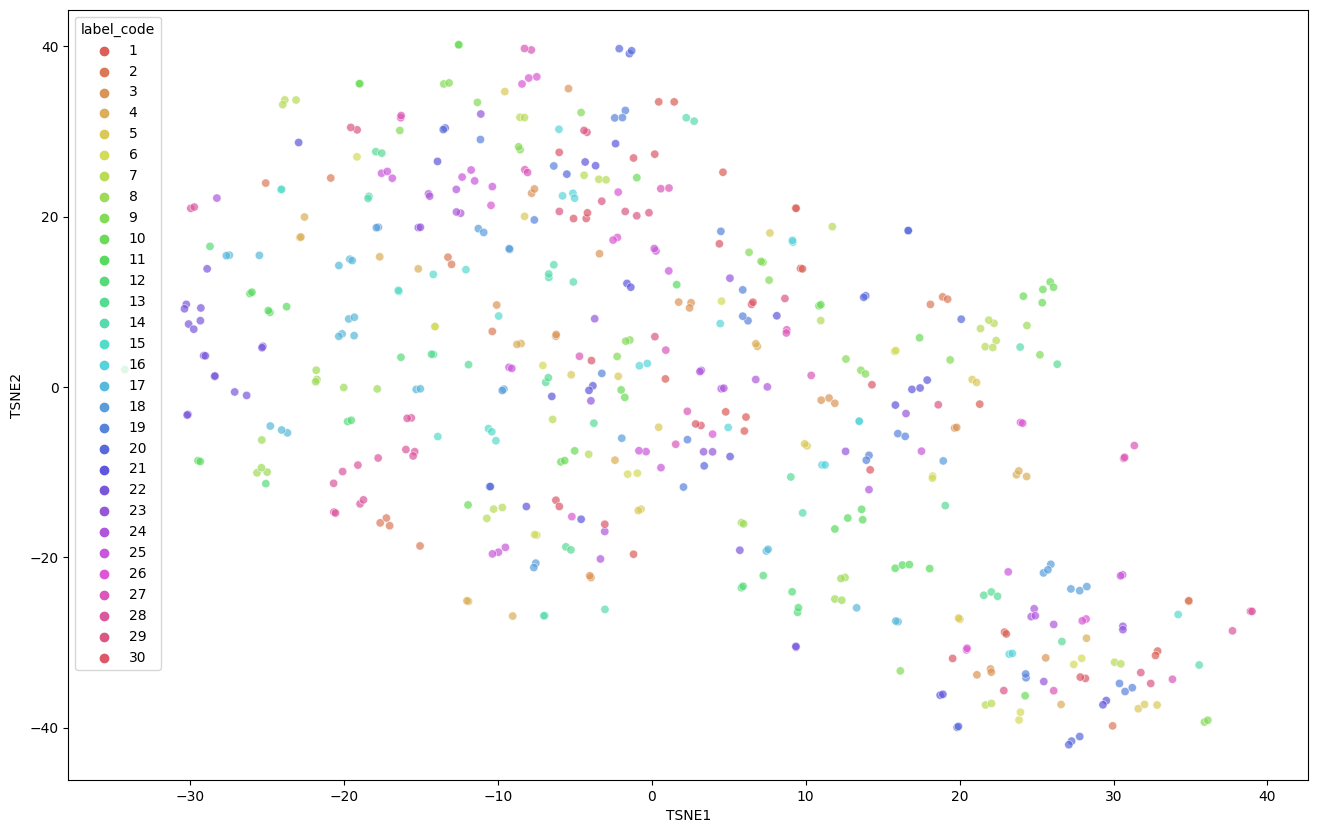

In [6]:
def tSNE_scatter(df, feature_columns, label_column):

    df = df.copy()

    # Let's also try t-SNE
    tsne = TSNE(n_components=2, verbose=1, random_state=9999) #, perplexity=80, n_iter=10000)
    tsne_results = tsne.fit_transform(df[feature_columns].values)

    df_train['TSNE1'] = tsne_results[:,0]
    df_train['TSNE2'] = tsne_results[:,1]
    plt.figure(figsize=(16,10))

    sns.scatterplot(
        x="TSNE1", y="TSNE2",
        hue=label_column,
        palette=sns.color_palette("hls", n_classes),
        data=df_train,
        legend="full",
        alpha=0.7
    )

tSNE_scatter(df_train, train_feature_columns, "label_code")